<!-- # <span style='background:lightblue'> Single-impurity ground-state correlations in 2D</span> -->
# Single-impurity ground-state correlations in 2D

In [1]:
include("../src/GroundStateCorrelations2D.jl")
using .GroundStateCorrelations2D

<!-- ## <span style='background:lightgreen'> Impurity-bath correlations</span> -->
## Impurity-bath correlations

Neglecting the lower bound state contribution, the impurity-bath correlations in the ground state can be expressed as

$$\langle c^\dagger b_j \rangle \approx \int_0^{2\pi} \frac{dk}{2\pi} \, e^{ikr'} \mathrm{Re}\left[f_1(k) + f_2(k)\right] \,,$$

with $r' = \sqrt{m^2 + n^2} \lvert \mathbf{r}_j\rvert$, assuming $\mathbf{r}_j \propto (m, n)$.
They can be computed efficiently using a fast Fourier transform algorithm.
Defining a one-dimensional array $A$ with components 

$$A[l] = \mathrm{Re}\left[f_1(k_l) + f_2(k_l)\right]\,, \ k_l \equiv \frac{\pi(l - 1)}{M} \quad (l = 1, \dots, 2M)\,,$$

its discrete Fourier transform has components

$$\mathrm{IDFT}(A)[j] = \frac{1}{2M} \sum_{l = 1}^{2M} e^{ik_l (j - 1)} A[l] \quad (j = 1,\dots, 2M) \,,$$

and we can approximate $\langle c^\dagger b_j\rangle \approx \mathrm{IDFT}(A)[j]$, assuming $\lvert\mathbf{r}_j\rvert = (j - 1)/\sqrt{m^2 + n^2}$, for sufficiently large $M$.

In [2]:
?impurity_correlations_10

search: impurity_correlations_10 impurity_correlations_11



```
dist, corr = impurity_correlations_10(Delta, g, Ef, M)
```

Compute impurity-bath ground-state correlations along spatial direction (1, 0) at  various distances from the impurity.

#### Arguments

  * `Delta`: impurity on-site energy.
  * `g`: impurity-bath coupling strength.
  * `Ef`: Fermi level (function is valid only for Ef < 4).
  * `M`: number of points (2M) in momentum space for the FFT.

#### Outputs

  * `dist`: distances from the impurity at which correlations are evaluated.
  * `corr`: impurity-bath correlations.


In [3]:
Delta = 3.8
g = 0.5
Ef = 3.8
M = 2^16

# compute correlations along direction (1, 0)
@time dist_10, corrs_10 = impurity_correlations_10(Delta, g, Ef, M);

167.076261 seconds (8.27 M allocations: 889.266 MiB, 0.12% gc time, 1.92% compilation time)


In [4]:
# compute correlations along direction (1, 1)
@time dist_11, corrs_11 = impurity_correlations_11(Delta, g, Ef, M);

216.424139 seconds (2.08 M allocations: 673.724 MiB, 0.13% gc time, 0.50% compilation time)


In [5]:
using Plots

plot(
    xlabel = "\$|\\mathbf{r}_j|\$", ylabel = "\$|\\langle c^\\dagger b_j\\rangle_\\mathrm{GS}|\$",
    xscale = :log10, yscale = :log10,
    xlim = (1, 1e4), ylim = (1e-7, 1)
)

plot!(dist_10[2:end], abs.(corrs_10[2:end]), label = "\$\\mathbf{r}_j\\propto(1,0)\$", alpha = 0.5)
plot!(dist_11[2:end], abs.(corrs_11[2:end]), label = "\$\\mathbf{r}_j\\propto(1,1)\$", alpha = 0.5)

<!-- # <span style='background:lightgreen'> Bath-bath correlations</span> -->
# Bath-bath correlations

Neglecting the lower bound state contribution, the bath-bath correlations can be computed as

$$\langle b^\dagger_0 b_j \rangle_\mathrm{GS} - \langle b^\dagger_0 b_j \rangle_\mathrm{FS} \approx \int_\mathrm{BZ} \frac{d^2\mathbf{k}}{(2\pi)^2} \, e^{i \mathbf{k}\cdot\mathbf{r}_j} f_1(\omega_\mathbf{k}) + \int_0^{2\pi} \frac{dk}{2\pi} \, e^{i k r^x_j} f_2(k, r^y_j) \,,$$

with

\begin{align}
f_1(\omega) & = G_e(\omega^-) \Sigma_e(\omega^-) \Theta(E_F - \omega) \,, \\
f_2(k, r^y) & = \int_0^{E_F} d\epsilon \, \rho(\epsilon)\lvert G_e(\epsilon^+)\rvert^2 (\epsilon - \Delta)\sigma(\epsilon^+, k, r^y) \,.
\end{align}

Where

$$\sigma(z, k, r) = g^2 \int_0^{2\pi} \frac{dq}{2\pi}\, \frac{e^{iqr}}{z - \omega(k, q)} = \frac{g^2\mathrm{sign}(\mathrm{Re}(b))}{J\sqrt{b^2 - 4}} \left[\frac{-b + \mathrm{sign}(\mathrm{Re}(b))\sqrt{b^2 - 4}}{2}\right]^{\lvert r\rvert}\,,\quad b(z, k) = \frac{z}{J} + 2 \cos k - 4 \,.$$

In [2]:
?bath_correlations

search: bath_correlations



```
corr = bath_correlations(Delta, g, Ef, M)
```

Compute the difference between the bath-bath correlations in the ground state with and  without the impurity.

#### Arguments

  * `Delta`: impurity on-site energy
  * `g`: impurity-bath coupling strength.
  * `Ef`: Fermi level.
  * `M`: number of points for the FFT (2M x 2M).

#### Outputs

  * `corr`: bath-bath correlations (deviation from impurity-free case).


In [11]:
Delta = 1.0
g = 0.2
Ef = 1.0
M = 2^7

# compute correlations
@time corrs = bath_correlations(Delta, g, Ef, M);

 63.750185 seconds (96.74 k allocations: 68.755 MiB, 0.02% gc time)


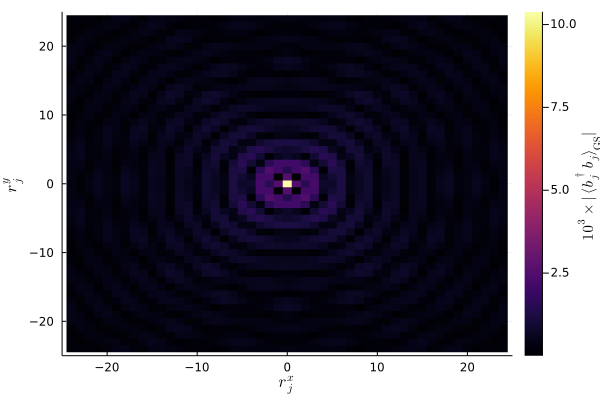

In [18]:
using CircularArrays, Plots

data = CircularArray(abs.(corrs))
r = -24:24
ir = (r[1] + 1):(r[end] + 1)    # julia indexing 
heatmap(r, r, 1e3*data[ir, ir],
    xlabel = "\$r_j^x\$", ylabel = "\$r_j^y\$",
    xlim = (-25, 25), ylim = (-25, 25),
    colorbar_title = "\$10^3\\times|\\langle b_j^\\dagger b_j\\rangle_\\mathrm{GS}|\$"
)